In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Importing the dataset
df = pd.read_csv("2_shopping_trends.csv")
df

,Age,Gender,Item Purchased,Category,Location,Season,Review Rating,Discount Applied,Promo Code Used,Previous Purchases,Frequency of Purchases,Purchase Intent Category
0,33,Male,Backpack,Accessories,Malaysia,Summer,4.5,Yes,Yes,44,Fortnightly,Wants-based
1,39,Female,Jeans,Clothing,Spain,Winter,5.0,No,No,23,Fortnightly,Wants-based
2,23,Male,Dress,Clothing,Australia,Spring,3.2,No,No,30,Weekly,Wants-based
3,39,Male,Backpack,Accessories,United Kingdom,Fall,3.1,Yes,Yes,19,Weekly,Wants-based
4,34,Female,Gloves,Accessories,Nigeria,Winter,2.8,No,No,16,Annually,Wants-based
...,...,...,...,...,...,...,...,...,...,...,...,...
12939,53,Male,Sneakers,Footwear,Canada,Fall,4.4,Yes,Yes,1,NaN,Impulsive
12940,54,Male,Jewelry,Accessories,Thailand,Summer,4.3,Yes,Yes,1,NaN,Impulsive
12941,56,Female,Boots,Footwear,United States,Summer,3.8,No,No,2,NaN,Impulsive
12942,52,Female,Coat,Outerwear,Spain,Spring,3.0,No,No,2,NaN,Impulsive


In [2]:
# Drop unused columns
cleaned_df = df.copy()
cleaned_df.drop(columns=[col for col in df.columns if col not in ['Gender', 'Item Purchased', 'Category', 'Location', 'Season',
                                                                  'Discount Applied', 'Promo Code Used', 'Purchase Intent Category', 
                                                                  'Frequency of Purchases']], inplace=True)
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12944 entries, 0 to 12943
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Gender                    12944 non-null  object
 1   Item Purchased            12944 non-null  object
 2   Category                  12944 non-null  object
 3   Location                  12944 non-null  object
 4   Season                    12944 non-null  object
 5   Discount Applied          12944 non-null  object
 6   Promo Code Used           12944 non-null  object
 7   Frequency of Purchases    3900 non-null   object
 8   Purchase Intent Category  12944 non-null  object
dtypes: object(9)
memory usage: 910.3+ KB


In [3]:
#check missing values
print("\nMising Value:\n",cleaned_df.isnull().sum())

#check datatype for each columns
print("\nDatatype for each column\n",cleaned_df.dtypes)

#check duplicate values
df.duplicated().sum()


Mising Value:
 Gender                         0
Item Purchased                 0
Category                       0
Location                       0
Season                         0
Discount Applied               0
Promo Code Used                0
Frequency of Purchases      9044
Purchase Intent Category       0
dtype: int64

Datatype for each column
 Gender                      object
Item Purchased              object
Category                    object
Location                    object
Season                      object
Discount Applied            object
Promo Code Used             object
Frequency of Purchases      object
Purchase Intent Category    object
dtype: object


2056

In [4]:
# handle missing values
cleaned_df['Frequency of Purchases'] = cleaned_df['Frequency of Purchases'].fillna(cleaned_df['Frequency of Purchases'].mode()[0])

# check missing values
print("\nMissing Value:\n",cleaned_df.isnull().sum())

# Save the cleaned dataframe to a CSV file
cleaned_df.to_csv("cleaned_shopping_trends.csv", index=False)


Missing Value:
 Gender                      0
Item Purchased              0
Category                    0
Location                    0
Season                      0
Discount Applied            0
Promo Code Used             0
Frequency of Purchases      0
Purchase Intent Category    0
dtype: int64


### KMeans Clustering

In [17]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from collections import Counter

# Encode categorical variables
categorical_cols = ['Gender', 'Item Purchased', 'Category', 'Location', 'Season',
                    'Discount Applied', 'Promo Code Used', 'Purchase Intent Category', 
                    'Frequency of Purchases']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    cleaned_df[col] = le.fit_transform(cleaned_df[col])
    label_encoders[col] = le


In [18]:
cluster_df = cleaned_df.copy()

# Features for clustering
features = ['Category', 'Frequency of Purchases']
X = cluster_df[features]

# Apply KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_df['Cluster'] = kmeans.fit_predict(X)

In [19]:
# cluster profile report
cluster_profiles = []
for cluster_id in sorted(cluster_df['Cluster'].unique()):
    cluster_data = cluster_df[cluster_df['Cluster'] == cluster_id]
    profile = {
        'Cluster': cluster_id,
        'Count': len(cluster_data),
        'Dominant Category': cluster_data['Category'].mode()[0],
        'Top Item Purchased': cluster_data['Item Purchased'].mode()[0],
        'Common Frequency of Purchases': cluster_data['Frequency of Purchases'].mode()[0],
        'Top Gender': cluster_data['Gender'].mode()[0],
        'Top Location': cluster_data['Location'].mode()[0],
        'Top Season': cluster_data['Season'].mode()[0],
        'Top Discount Applied': cluster_data['Discount Applied'].mode()[0],
        'Top Promo Code Used': cluster_data['Promo Code Used'].mode()[0],
        'Top Purchase Intent Category': cluster_data['Purchase Intent Category'].mode()[0]
    }
    cluster_profiles.append(profile)

# Display cluster profiles
profile_df = pd.DataFrame(cluster_profiles)
profile_df

,Cluster,Count,Dominant Category,Top Item Purchased,Common Frequency of Purchases,Top Gender,Top Location,Top Season,Top Discount Applied,Top Promo Code Used,Top Purchase Intent Category
0,0,4612,1,16,2,1,19,1,0,0,2
1,1,1616,1,19,5,1,19,0,0,0,3
2,2,533,1,18,0,1,22,1,0,0,3
3,3,2844,2,10,2,1,22,1,0,0,0
4,4,3339,0,22,2,1,19,0,0,0,1


In [8]:
# evaluation
from sklearn.metrics import silhouette_score

score = silhouette_score(X, kmeans.labels_)
print("Silhouette Score:", score)
print("Inertia:", kmeans.inertia_)


Silhouette Score: 0.7134731834399382
Inertia: 4558.018769256066


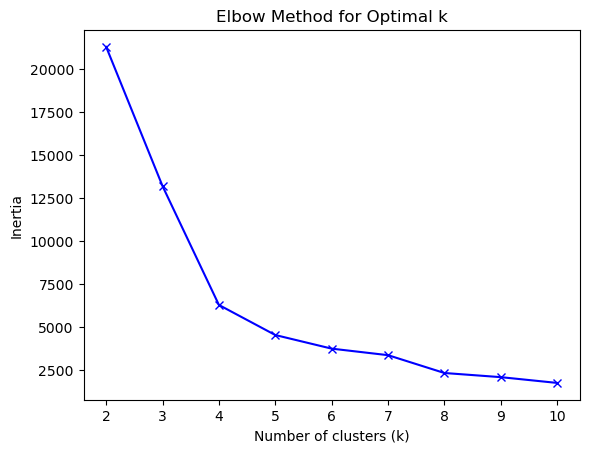

In [9]:
import matplotlib.pyplot as plt

inertia_values = []
K = range(2, 11)  # Test k fimport matplotlib.pyplot as plt

inertia_values = []
K = range(2, 11)  # Test k from 2 to 10
for k in K:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X)
    inertia_values.append(model.inertia_)

plt.plot(K, inertia_values, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

### Apriori - Association Rules

In [10]:
# Association Rule Mining with error handling
from mlxtend.frequent_patterns import apriori, association_rules
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

# creating a basket of items per cluster
results = []

for cluster_id in sorted(cluster_df['Cluster'].unique()):
    cluster_data = cluster_df[cluster_df['Cluster'] == cluster_id]
    
    print(f"Processing Cluster {cluster_id} with {len(cluster_data)} samples")
    
    # Skip clusters with too few samples
    if len(cluster_data) < 10:
        print(f"Skipping Cluster {cluster_id} - insufficient samples")
        continue

    # Create a feature dataset with selected variables
    features = cluster_data[['Gender', 'Item Purchased', 'Category', 'Location',
                               'Season', 'Discount Applied', 'Promo Code Used',
                               'Purchase Intent Category', 'Frequency of Purchases']]
    
    # Convert to one-hot encoding for Apriori
    onehot = pd.get_dummies(features)
    
    # Check if we have enough variation in the data
    if onehot.sum().sum() < 20:  # Total number of True values
        print(f"Skipping Cluster {cluster_id} - insufficient variation")
        continue
    
    try:
        # Apply Apriori algorithm with lower min_support
        frequent_itemsets = apriori(onehot, min_support=0.01, use_colnames=True)
        
        if len(frequent_itemsets) < 2:
            print(f"Skipping Cluster {cluster_id} - insufficient frequent itemsets")
            continue
            
        rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0.5)
        
        if len(rules) > 0:
            # Select top 5 rules by lift
            top_rules = rules.sort_values(by='lift', ascending=False).head(5)
            top_rules['Cluster'] = cluster_id
            results.append(top_rules)
        else:
            print(f"No rules found for Cluster {cluster_id}")
            
    except Exception as e:
        print(f"Error processing Cluster {cluster_id}: {e}")
        continue

# Combine all cluster rules into one DataFrame
if results:
    final_rules = pd.concat(results, ignore_index=True)
    
    # Save the rules to a CSV file
    final_rules.to_csv("cluster_apriori_rules.csv", index=False)
    
    # Display summary of top rules per cluster
    summary = final_rules[['Cluster', 'antecedents', 'consequents', 'support', 'confidence', 'lift']]
    print("\nAssociation Rules Summary:")
    print(summary)
else:
    print("No association rules found for any cluster")

Processing Cluster 0 with 4612 samples
Error processing Cluster 0: The allowed values for a DataFrame are True, False, 0, 1. Found value 11
Processing Cluster 1 with 1616 samples
Error processing Cluster 1: The allowed values for a DataFrame are True, False, 0, 1. Found value 5
Processing Cluster 2 with 533 samples
Error processing Cluster 2: The allowed values for a DataFrame are True, False, 0, 1. Found value 6
Processing Cluster 3 with 2844 samples
Error processing Cluster 3: The allowed values for a DataFrame are True, False, 0, 1. Found value 17
Processing Cluster 4 with 3339 samples
Error processing Cluster 4: The allowed values for a DataFrame are True, False, 0, 1. Found value 11
No association rules found for any cluster


/Users/farahfuaad/anaconda3/envs/myenv/lib/python3.12/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/Users/farahfuaad/anaconda3/envs/myenv/lib/python3.12/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/Users/farahfuaad/anaconda3/envs/myenv/lib/python3.12/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/Users/farahfuaad/anaconda3/envs/myenv/lib/python3.12/site-packa

In [11]:
# Readable Apriori Results
df = pd.read_csv("cluster_apriori_rules.csv")

# Clean text
def clean_text(text):
    text = text.replace("frozenset({", "").replace("})", "")
    text = text.replace("_", " ").replace("'", "")
    return text

df['antecedents'] = df['antecedents'].apply(clean_text)
df['consequents'] = df['consequents'].apply(clean_text)

# Create readable rule
df['Rule'] = "If " + df['antecedents'] + " then " + df['consequents']

# Select top 3 per cluster
top_rules = df.groupby('Cluster').apply(lambda x: x.nlargest(3, 'lift')).reset_index(drop=True)

# Display
top_rules[['Cluster', 'Rule', 'support', 'confidence', 'lift']].style.set_properties(
    subset=['Rule'],
    **{'white-space': 'pre-line', 'word-break': 'break-word', 'max-width': '350px'}
)


/var/folders/4h/yv7v_s3x45ndtl40qwsynt_00000gn/T/ipykernel_10075/4283781400.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_rules = df.groupby('Cluster').apply(lambda x: x.nlargest(3, 'lift')).reset_index(drop=True)


,Cluster,Rule,support,confidence,lift
0,0,"If Item Purchased Shorts, Purchase Intent Category Impulsive then Discount Applied No, Gender Female, Season Spring, Frequency of Purchases Every 3 Months, Promo Code Used No, Location Netherlands",0.010408,1.000000,96.083333
1,0,"If Category Clothing, Gender Female, Season Spring, Frequency of Purchases Every 3 Months, Location Netherlands then Item Purchased Shorts, Purchase Intent Category Impulsive",0.010408,1.000000,96.083333
2,0,"If Item Purchased Shorts, Purchase Intent Category Impulsive then Category Clothing, Gender Female, Season Spring, Frequency of Purchases Every 3 Months, Location Netherlands",0.010408,1.000000,96.083333
3,1,"If Category Outerwear, Frequency of Purchases Quarterly, Discount Applied Yes then Promo Code Used Yes, Item Purchased Jacket",0.010520,0.629630,46.249158
4,1,"If Promo Code Used Yes, Item Purchased Jacket then Category Outerwear, Frequency of Purchases Quarterly, Gender Male, Discount Applied Yes",0.010520,0.772727,46.249158
5,1,"If Category Outerwear, Frequency of Purchases Quarterly, Discount Applied Yes then Promo Code Used Yes, Gender Male, Item Purchased Jacket",0.010520,0.629630,46.249158
6,2,"If Category Footwear, Purchase Intent Category Wants-based, Gender Female then Frequency of Purchases Annually, Promo Code Used No, Discount Applied No, Item Purchased Sneakers",0.011257,0.285714,21.755102
7,2,"If Promo Code Used No, Discount Applied No, Item Purchased Sneakers then Category Footwear, Frequency of Purchases Annually, Purchase Intent Category Wants-based, Gender Female",0.011257,0.857143,21.755102
8,2,"If Category Footwear, Frequency of Purchases Annually, Purchase Intent Category Wants-based, Gender Female then Promo Code Used No, Discount Applied No, Item Purchased Sneakers",0.011257,0.285714,21.755102
9,3,"If Discount Applied No, Item Purchased Shoes, Purchase Intent Category Impulsive then Gender Male, Season Summer, Location Kenya, Frequency of Purchases Every 3 Months, Promo Code Used No",0.010197,1.000000,98.068966


In [12]:
# Simple Trending Item Analysis (Alternative to Association Rules)
print("=== TRENDING ITEM ANALYSIS BY CLUSTER ===\n")

# Analyze trending items per cluster
for cluster_id in sorted(cluster_df['Cluster'].unique()):
    cluster_data = cluster_df[cluster_df['Cluster'] == cluster_id]

    print(f"CLUSTER {cluster_id} ({len(cluster_data)} customers)")
    print("-" * 40)
    
    # Top items
    top_items = cluster_data['Item Purchased'].value_counts().head(3)
    print("Top Items:")
    for item, count in top_items.items():
        percentage = (count / len(cluster_data)) * 100
        print(f"  • {item}: {count} ({percentage:.1f}%)")
    
    # Dominant characteristics
    print(f"\nDominant Characteristics:")
    print(f"  • Gender: {cluster_data['Gender'].mode()[0]}")
    print(f"  • Category: {cluster_data['Category'].mode()[0]}")
    print(f"  • Season: {cluster_data['Season'].mode()[0]}")
    print(f"  • Location: {cluster_data['Location'].mode()[0]}")
    print(f"  • Purchase Frequency: {cluster_data['Frequency of Purchases'].mode()[0]}")
    print("\n")


    

=== TRENDING ITEM ANALYSIS BY CLUSTER ===

CLUSTER 0 (4612 customers)
----------------------------------------
Top Items:
  • 16: 526 (11.4%)
  • 23: 491 (10.6%)
  • 13: 487 (10.6%)

Dominant Characteristics:
  • Gender: 1
  • Category: 1
  • Season: 1
  • Location: 19
  • Purchase Frequency: 2


CLUSTER 1 (1616 customers)
----------------------------------------
Top Items:
  • 19: 82 (5.1%)
  • 16: 81 (5.0%)
  • 12: 76 (4.7%)

Dominant Characteristics:
  • Gender: 1
  • Category: 1
  • Season: 0
  • Location: 19
  • Purchase Frequency: 5


CLUSTER 2 (533 customers)
----------------------------------------
Top Items:
  • 18: 31 (5.8%)
  • 6: 29 (5.4%)
  • 17: 27 (5.1%)

Dominant Characteristics:
  • Gender: 1
  • Category: 1
  • Season: 1
  • Location: 22
  • Purchase Frequency: 0


CLUSTER 3 (2844 customers)
----------------------------------------
Top Items:
  • 10: 640 (22.5%)
  • 4: 613 (21.6%)
  • 14: 462 (16.2%)

Dominant Characteristics:
  • Gender: 1
  • Category: 2
  • Season: